In [73]:
import numpy as np
import scipy.spatial.distance as dist

In [74]:
class UnionFind:
    
    def __init__(self, N):
        self.parent = np.array([-1] * (2*N-1))
        self.next_label = N
        self.size = np.array([1] * N)
        self.size = np.concatenate([self.size, np.array([0] * (N-1))])
        
    def union(self, m, n):
        self.size[self.next_label] = self.size[m] + self.size[n]
        self.parent[m] = self.next_label
        self.parent[n] = self.next_label
        self.size[self.next_label] = self.size[m] + self.size[n]
        self.next_label += 1
        
    def find(self, n):
        while self.parent[n] != -1 :
            n = self.parent[n]
        return n
    
    def fast_find(self, n):
        p = n
        while self.parent[n] != -1 :
            n = self.parent[n]
        while self.parent[p] != n: # label all the way up to the root
            (p, self.parent[p]) = (self.parent[p], n)
        return n

### Mutual Reachability "Graph"

Build the mutual reachability graph from a distance matrix. We are operating with the following definitions per 'Campello, Moulavi, Sander':

**Core Distance**: The core distance of an object $x_p \in X$ with respect to $m_{\textrm{pts}}$ is the distance from $x_p$ to its $m_{\textrm{pts}}$-nearest neighbour.

**Mutual Reachability Distance**: The mutual reachability distance between two objects $x_p$ and $x_q$ in $X$ with respect to $m_{\textrm{pts}}$ is defined as $d_{\textrm{mreach}} = \max\{d_{\textrm{core}}(x_p), d_{\textrm{core}}(x_q), d(x_p, x_q)\}$.

### Core Single Linkage via Minimal Spanning Tree
Working from Mullner's paper we are going to implement our own MST-LINKAGE-CORE so we can handle HDBSCANs mutual reachability graphs (which have non-zero self distances). The goal here is to start with a simple implemetation and then progressively profile and refine and use whatever we can (cython, numba, etc.) to try and make it run as fast as possible because this is the core of the algorithm.

### Label
Code based on algorithm on pg 14 of "Modern hierarchical, agglomerative clustering algorithms" by Daniel Mullner

**Input:** numpy array of triples: (a, b, delta) where a and b are points (representing clusters) that were merged together at time delta. The array must already be sorted by delta.

**Output:** array of triples (ca, cb, delta) where ca, cb are cluster labels that are being merged at time delta.

**Notes:**
pg 14 error in Label(L): should call U.UNION() with find(a), find(b) rather than a, b

In [75]:
class Hdbscan:
    
    def label(self, L, do_fast_find=True):
        LL = []
        N = len(L) + 1 # QUESTION: why isn't this len(L)??
        U = UnionFind(N)
        for idx, (a, b, delta) in enumerate(L):
            if do_fast_find:
                aa, bb = (U.fast_find(a), U.fast_find(b))
            else:
                aa, bb = (U.find(a), U.find(b))
            LL.append((aa, bb, delta, U.size[aa] + U.size[bb]))      
            U.union(aa, bb)
        return LL

     # from Mutual Reachability notebook
    def mutual_reachability_distance_matrix(self, distance_matrix, min_points):
        core_distances = np.partition(distance_matrix, min_points, axis=0)[min_points]
        core_distance_matrix = core_distances.repeat(len(distance_matrix)).reshape(distance_matrix.shape())
        result = np.dstack((core_distance_matrix, core_distance_matrix.T, distance_matrix)).max(axis=2)
        return result
    
    def base_mst_linkage_core(self, node_labels, distance_matrix):
        result = []
        current_node = np.random.choice(node_labels)
        level_distances = np.infty * np.ones((node_labels.shape[0], node_labels.shape[0]))
        current_labels = node_labels
        for i in xrange(1,node_labels.shape[0]):
            current_labels = current_labels[current_labels != current_node]
            for other_node in current_labels:
                level_distances[i][other_node] = min(level_distances[i-1][other_node], 
                                                    distance_matrix[other_node,current_node])

            new_node_index = np.argmin(level_distances[i][current_labels])
            new_node = current_labels[new_node_index]
            result.append([current_node, new_node, level_distances[i][new_node]])
            current_node = new_node
        return result
    
    def linkage(self, data):
        distance_matrix = dist.squareform(dist.pdist(data))
        labels = np.arange(len(data))
        hierarchy = np.array(self.base_mst_linkage_core(labels, distance_matrix))
        sort_order = np.argsort(hierarchy.T[2])
        data_for_steve = hierarchy[sort_order,:]
        return self.label(data_for_steve)

## Test

In [76]:
import sklearn.datasets

In [77]:
iris = sklearn.datasets.load_iris()

In [78]:
clu = Hdbscan()

In [79]:
z = clu.linkage(iris.data)

In [80]:
import scipy.cluster.hierarchy as hac
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

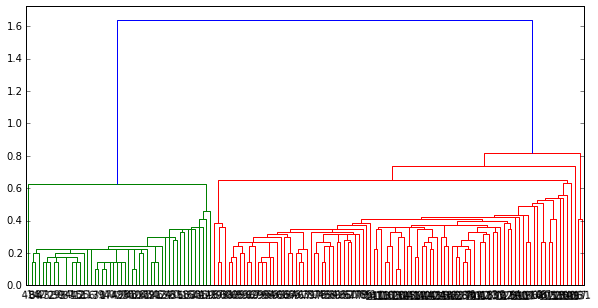

In [81]:
R = hac.dendrogram(z)

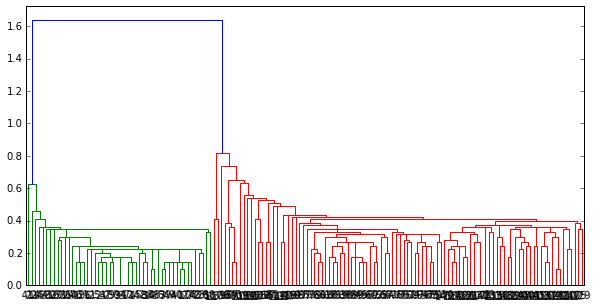

In [70]:
R = hac.dendrogram(hac.linkage(iris.data))